# Classifying heatmaps
They extract a bunck of features (28) from each heatmap, and then classify it based on random forest. Examples are:
* percentage of tumor region over the whole tissue region, 
* area ratio between tumor region and the minimum surrounding convex region
* average prediction values
* longest axis of the tumor region

In [1]:
import os
import sys
import glob
import random
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
from sklearn.metrics import accuracy_score

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Add the src directory for functions
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'src')
print(src_dir)
sys.path.append(src_dir)

PATH = '/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1'

/media/rene/Data/camelyon/src


(738, 327, 2)
53784.533994894475
398107.7248727456
-160.9815673828125
156.83749389648438


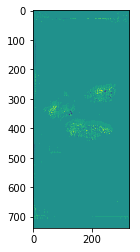

In [2]:
heatmap_loc = PATH+'/train/'+ 'normal29heatmap.npy'#'normal100heatmap.npy'
heatmap = np.load(heatmap_loc)
print(heatmap.shape)
plt.figure()
plt.imshow(heatmap[:, :, 0])
print(np.sum(heatmap[:300, :, 1]))
print(np.sum(heatmap[:, :, 0]))
print(np.amin(heatmap[:, :, 0]))
print(np.amax(heatmap[:, :, 0]))

Identifying Metastatic Breast Cancer using Deep Texture Representation  Team MIL-GPAT

Features:
* Tumor area in the largest region with threshold t = {0.5, 0.7 0.9}
* Major axis length of the largest region with threshold t = {0.5, 0.7 0.9}
* Eccentricity of the largest region with threshold t = {0.5, 0.7 0.9}
* Mean probability of the largest region with threshold t = {0.5, 0.7 0.9}
* The number of  region with threshold t = {0.5, 0.7 0.9}

## Making features:
Some example code: https://github.com/arjunvekariyagithub/camelyon16-grand-challenge/blob/master/camelyon16/postprocess/extract_feature_heatmap.py

http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_regionprops.html

In [31]:
import scipy.stats.stats as st
from skimage.measure import label
from skimage.measure import regionprops

def make_features(heatmap, threshold_list = [.5, .7, .9]):
    """return a list of features from the heatmap. 
    Features are from on the largest region in the heatmap at different thresholds
    Features are added without any labels, because we just throw them into a classifier.
    """
    
    heatmap = np.squeeze(np.array(heatmap))[:, :, 0]
    
    # thanks https://github.com/arjunvekariyagithub/camelyon16-grand-challenge/blob/master/camelyon16/postprocess/extract_feature_heatmap.py
    def get_region_props(heatmap_mask, heatmap):
        labeled_img = label(heatmap_mask)
        return regionprops(labeled_img, intensity_image=heatmap)
    
    def get_region_prop_summary_stat(region_props, feature_name):
        feature_values = [region[feature_name] for region in region_props]
        summary_stats = []
        if len(region_props) > 0: # check if there are any regions
            summary_stats.append(np.max(feature_values))
            summary_stats.append(np.mean(feature_values))
            summary_stats.append(np.var(feature_values))
            summary_stats.append(st.skew(np.array(feature_values)))
            summary_stats.append(st.kurtosis(np.array(feature_values)))
        else:
            summary_stats = [0]*5
        return summary_stats
    
    def get_largest_tumor_index(region_props):
        largest_tumor_index = -1
        largest_tumor_area = -1
        n_regions = len(region_props)
        for index in range(n_regions):
            if region_props[index]['area'] > largest_tumor_area:
                largest_tumor_area = region_props[index]['area']
                largest_tumor_index = index
        return largest_tumor_index
    
    def get_max_region_stats(region_props):
        stats = []
        if len(region_props) > 0:
            # find the largest region
            ind = get_largest_tumor_index(region_props)
            #get all the relevant features from largest region
            stats.append(region_props[ind]['eccentricity'])
            stats.append(region_props[ind]['mean_intensity'])
            stats.append(max(region_props[ind]['major_axis_length'], region_props[ind]['minor_axis_length']))
        else:
            stats = [0]*3
        return stats
        
    
    heatmap_masks = {threshold:[heatmap>threshold]  for threshold in threshold_list}
    features = []
    
    for threshold, threshold_mask in heatmap_masks.items(): 
        # look at only one probability
        threshold_mask = np.squeeze(np.array(threshold_mask))

        # get all the regions
        region_props = get_region_props(np.squeeze(np.array(threshold_mask)), heatmap)
        
        # number of regions
        features.append(len(region_props))
        
        # ratio of tumor region to tissue region
        tr_ratio = np.sum(threshold_mask)/np.count_nonzero(heatmap)
        features.append(tr_ratio)
        
        # Summary Stats for all regions
        feature_name_list = ['area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 
                             'perimeter', 'extent', 'solidity']
        for feature_name in feature_name_list:
            stats = get_region_prop_summary_stat(region_props, feature_name)
            features.extend(stats)
        
        stats = get_max_region_stats(region_props)
        features.extend(stats)
    
    return features

def make_features_simple(heatmap, threshold_list = [.7]):
    """return a list of features from the heatmap. 
    Features are from on the largest region in the heatmap at different thresholds
    Features are added without any labels, because we just throw them into a classifier.
    """
    
    heatmap = np.squeeze(np.array(heatmap))[:, :, 0]
    
    # thanks https://github.com/arjunvekariyagithub/camelyon16-grand-challenge/blob/master/camelyon16/postprocess/extract_feature_heatmap.py
    def get_region_props(heatmap_mask, heatmap):
        labeled_img = label(heatmap_mask)
        return regionprops(labeled_img, intensity_image=heatmap)
    
    def get_region_prop_summary_stat(region_props, feature_name):
        feature_values = [region[feature_name] for region in region_props]
        summary_stats = []
        if len(region_props) > 0: # check if there are any regions
            summary_stats.append(np.max(feature_values))
            summary_stats.append(np.mean(feature_values))
        else:
            summary_stats = [0]*5
        return summary_stats
    
    def get_largest_tumor_index(region_props):
        largest_tumor_index = -1
        largest_tumor_area = -1
        n_regions = len(region_props)
        for index in range(n_regions):
            if region_props[index]['area'] > largest_tumor_area:
                largest_tumor_area = region_props[index]['area']
                largest_tumor_index = index
        return largest_tumor_index
    
    def get_max_region_stats(region_props):
        stats = []
        if len(region_props) > 0:
            # find the largest region
            ind = get_largest_tumor_index(region_props)
            #get all the relevant features from largest region
            stats.append(region_props[ind]['eccentricity'])
            stats.append(region_props[ind]['mean_intensity'])
            stats.append(max(region_props[ind]['major_axis_length'], region_props[ind]['minor_axis_length']))
        else:
            stats = [0]*3
        return stats
        
    
    heatmap_masks = {threshold:[heatmap>threshold]  for threshold in threshold_list}
    features = []
    
    for threshold, threshold_mask in heatmap_masks.items(): 
        # look at only one probability
        threshold_mask = np.squeeze(np.array(threshold_mask))

        # get all the regions
        region_props = get_region_props(np.squeeze(np.array(threshold_mask)), heatmap)
        
        # number of regions
        features.append(len(region_props))
        
        # ratio of tumor region to tissue region
        tr_ratio = np.sum(threshold_mask)/np.count_nonzero(heatmap)
        features.append(tr_ratio)
        
        # Summary Stats for all regions
        feature_name_list = ['area', 'major_axis_length', 'minor_axis_length', 
                             'perimeter', 'extent', 'solidity']
        for feature_name in feature_name_list:
            stats = get_region_prop_summary_stat(region_props, feature_name)
            features.extend(stats)
        
        stats = get_max_region_stats(region_props)
        features.extend(stats)
    
    return features

In [34]:
heatmap_loc = PATH+'/train/'+ 'normal29heatmap.npy'#'normal100heatmap.npy'
heatmap = np.load(heatmap_loc)
make_softmax(heatmap)
features = make_features_simple(heatmap)
print(features)
print(len(features))

[502, 0.6379587155963303, 2330, 22.163346613545816, 104.77842789052215, 5.15960265688398, 57.10464883199234, 1.505907591746944, 1461.8925317304245, 14.654582888832167, 1.0, 0.852502526098673, 1.0, 0.9220664520863446, 0.7827917636166593, 0.7303595010594975, 91.76625554009846]
17


## Make heatmap features

In [36]:
def make_heatmap_features(data_loc, out_loc, threshold_list = [.5, .7, .9], simple = False):
    """Calculate features for the heatmap. Output is numpy array with col1 as class, col 2 slide num, then features"""
    ttv_folders = ['train', 'valid', 'test']
    for ttv in ttv_folders:
        all_features = [] 
        heatmap_locs = glob.glob(os.path.join(data_loc, ttv+'/**.npy'))
        for heatmap_loc in tqdm(heatmap_locs):
            wsi_id = int(''.join(filter(str.isdigit, heatmap_loc.rsplit('/', 1)[-1])))
            if 'normal' in heatmap_loc.lower():
                slide_class = 'normal'
            elif 'tumor' in heatmap_loc.lower():
                slide_class = 'tumor'
            elif 'test' in heatmap_loc.lower():
                slide_class = 'test'

            heatmap = np.load(heatmap_loc)
            make_softmax(heatmap) # because I didn't addd softmax to the end of the pytorch model
            if simple:
                features = make_features_simple(heatmap, threshold_list = threshold_list)
            else:
                features = make_features(heatmap, threshold_list = threshold_list)
            features.insert(0, wsi_id)
            features.insert(0, slide_class)
            all_features.append(features)
        all_features_loc = os.path.join(OUT_PATH, ttv+'_features.npy')
        np.save(all_features_loc, np.array(all_features))

In [11]:
PATH = '/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1/'
OUT_PATH = '/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1_feat/'

make_heatmap_features(PATH, OUT_PATH)

100%|██████████| 130/130 [03:23<00:00,  1.56s/it]


In [37]:
PATH = '/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1/'
OUT_PATH = '/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1_feat_simple/'

make_heatmap_features(PATH, OUT_PATH, threshold_list = [.7], simple = True)


  3%|▎         | 7/224 [00:07<03:51,  1.07s/it]
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/rene/miniconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 130/130 [02:34<00:00,  1.19s/it]


## Random Forest

In [57]:
train = np.load('/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1_feat_simple/train_features.npy')
valid = np.load('/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1_feat_simple/valid_features.npy')

train_x = train[:, 2:]
train_y = train[:, 0]
valid_x = valid[:, 2:]
valid_y = valid[:, 0]

print(train_x.shape)
print(valid_x.shape)

(224, 17)
(46, 17)


In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(train_x, train_y)

train_pred = clf.predict(train_x)
valid_pred = clf.predict(valid_x)

train_acc = accuracy_score(train_y, train_pred)
valid_acc = accuracy_score(valid_y, valid_pred)

print()
print('train_acc', train_acc)
print('valid_acc', valid_acc)


train_acc 1.0
valid_acc 0.6304347826086957


In [59]:
print(clf.feature_importances_)
print(valid_pred)

[0.07354338 0.08175773 0.07737653 0.04865951 0.04749003 0.0983145
 0.0641504  0.05401848 0.0541114  0.05647549 0.         0.06666071
 0.         0.06390026 0.05859934 0.10198158 0.05296068]
['tumor' 'normal' 'tumor' 'normal' 'normal' 'normal' 'normal' 'tumor'
 'tumor' 'normal' 'tumor' 'tumor' 'tumor' 'normal' 'normal' 'normal'
 'tumor' 'tumor' 'normal' 'tumor' 'tumor' 'normal' 'normal' 'normal'
 'tumor' 'normal' 'normal' 'normal' 'tumor' 'normal' 'normal' 'normal'
 'tumor' 'normal' 'normal' 'normal' 'normal' 'tumor' 'normal' 'tumor'
 'tumor' 'tumor' 'normal' 'tumor' 'normal' 'normal']


In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(train_x, train_y)

train_pred = clf.predict(train_x.astype(float))
valid_pred = clf.predict(valid_x.astype(float))

train_acc = accuracy_score(train_y, train_pred)
valid_acc = accuracy_score(valid_y, valid_pred)

print()
print('train_acc', train_acc)
print('valid_acc', valid_acc)


train_acc 0.6383928571428571
valid_acc 0.5217391304347826


In [65]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=1000, max_depth=3)
clf.fit(train_x, train_y)

train_pred = clf.predict(train_x)
valid_pred = clf.predict(valid_x)

train_acc = accuracy_score(train_y, train_pred)
valid_acc = accuracy_score(valid_y, valid_pred)

print()
print('train_acc', train_acc)
print('valid_acc', valid_acc)


train_acc 1.0
valid_acc 0.5434782608695652


In [66]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(train_x, train_y)

train_pred = clf.predict(train_x)
valid_pred = clf.predict(valid_x)

train_acc = accuracy_score(train_y, train_pred)
valid_acc = accuracy_score(valid_y, valid_pred)

print()
print('train_acc', train_acc)
print('valid_acc', valid_acc)


train_acc 1.0
valid_acc 0.6086956521739131


## Debug
* look at the heatmap and check if it lines up with the original slide
* Chack a threshold on the heatmap, see if it lines up at all with tumor region
* Look at the biggest regions identified

In [82]:
from WSI_utils import*

wsi_loc = '/media/rene/Data/CAMELYON16/TrainingData/Train_Tumor/Tumor_045.tif'
wsi = WSI(wsi_loc)
img = wsi.wsi.read_region(location=(0, 0), level=5, size=wsi.wsi.level_dimensions[5]).convert('RGB')

wsi.generate_mask(mask_level=5)

tumor_mask_loc = '/media/rene/Data/CAMELYON16/TrainingData/Ground_Truth/Mask/Tumor_045_Mask.tif'
annotation_wsi = OpenSlide(tumor_mask_loc)
tumor_mask = annotation_wsi.read_region(location=(0, 0), level=5, size=annotation_wsi.level_dimensions[5]).convert('RGB')

heatmap_loc = '/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1/train/tumor45heatmap.npy'
heatmap = np.load(heatmap_loc)

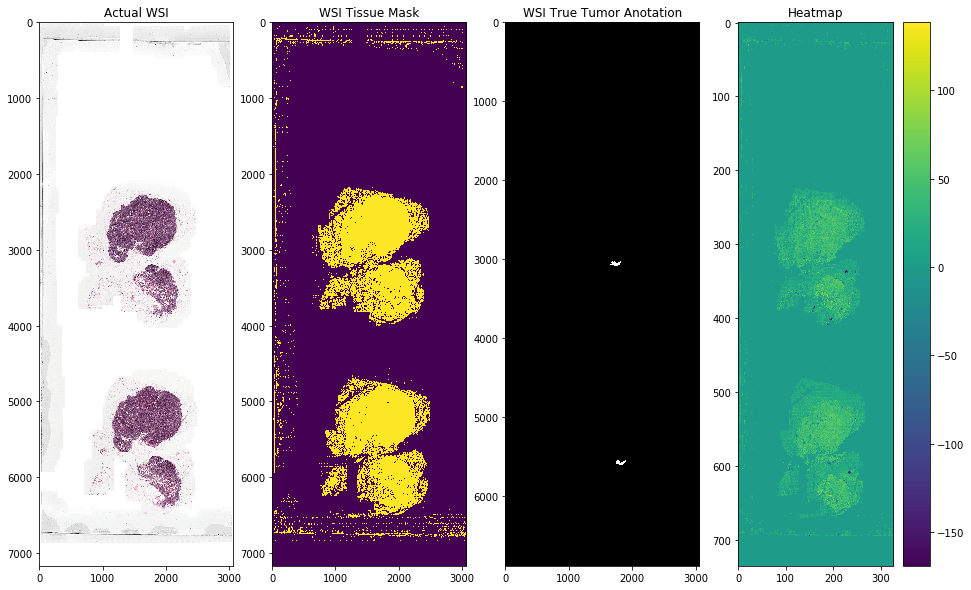

In [83]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 10))

ax1.imshow(img)
ax1.set_title('Actual WSI')
ax1.set_aspect('auto')

ax2.imshow(wsi.mask)
ax2.set_title('WSI Tissue Mask')
ax2.set_aspect('auto')

ax3.imshow(tumor_mask)
ax3.set_title('WSI True Tumor Anotation')
ax3.set_aspect('auto')

tmp = ax4.imshow(heatmap[:, :, 0])
ax4.set_title('Heatmap')
fig.colorbar(tmp)
ax4.set_aspect('auto')

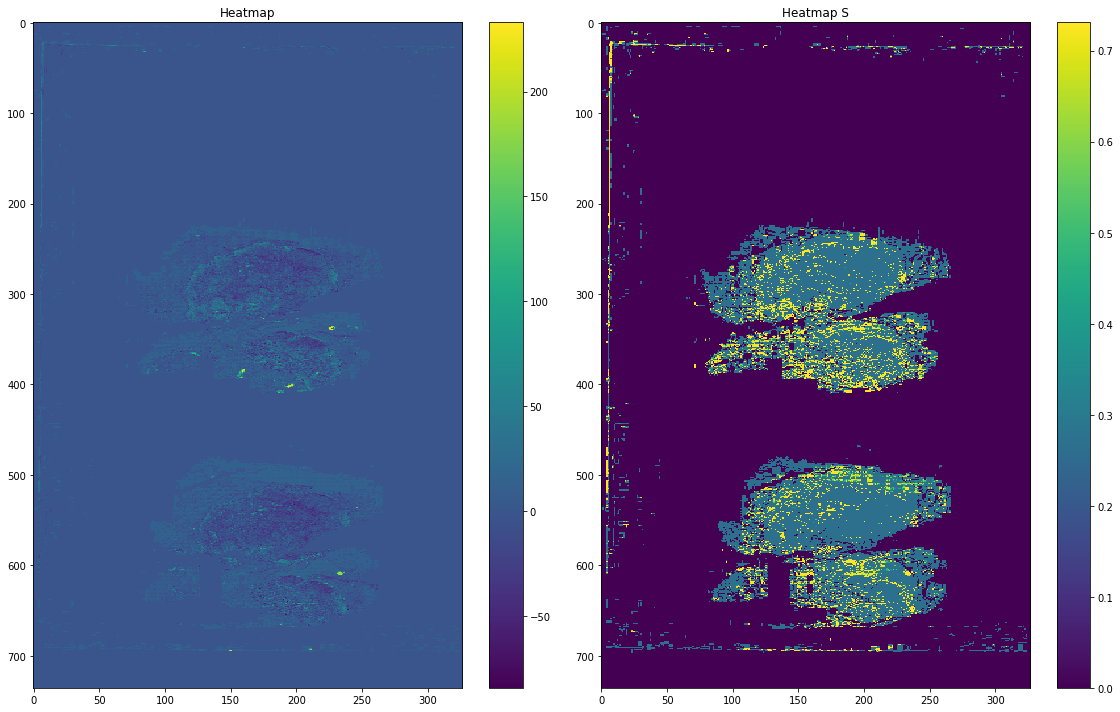

In [84]:
def make_softmax(heatmap):
    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    points = np.where(heatmap!=0)
    heatmap_s = heatmap
    
    for idx in range(len(points[0])):
        heatmap_s[points[0][idx], points[1][idx], :] = softmax(heatmap[points[0][idx], points[1][idx], :])
    return heatmap_s



heatmap_s = make_softmax(np.load(heatmap_loc))[:, :, 1]
heatmap = np.load(heatmap_loc)[:, :, 1]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 10))

tmp = ax1.imshow(heatmap)
ax1.set_title('Heatmap')
fig.colorbar(tmp, ax=ax1)
ax1.set_aspect('auto')

tmp2 = ax2.imshow(heatmap_s)
ax2.set_title('Heatmap S')
fig.colorbar(tmp2, ax=ax2)
ax2.set_aspect('auto')

plt.tight_layout(h_pad=1)

In [80]:
# look at the tumor region, check if the heat map has higher probability here compared to other tissue regions
from WSI_utils import*

wsi_loc = '/media/rene/Data/CAMELYON16/TrainingData/Train_Tumor/Tumor_010.tif'
wsi = WSI(wsi_loc)
img = wsi.wsi.read_region(location=(0, 0), level=8, size=wsi.wsi.level_dimensions[8]).convert('RGB')

wsi.generate_mask(mask_level=5)

tumor_mask_loc = '/media/rene/Data/CAMELYON16/TrainingData/Ground_Truth/Mask/Tumor_010_Mask.tif'
annotation_wsi = OpenSlide(tumor_mask_loc)
print(annotation_wsi.level_dimensions)
tumor_mask = annotation_wsi.read_region(location=(0, 0), level=7, size=annotation_wsi.level_dimensions[7]).convert('RGB')

heatmap_loc = '/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1/train/tumor10heatmap.npy'
heatmap = np.load(heatmap_loc)   
        

((97792, 215552), (48896, 107776), (24448, 53888), (12224, 26944), (6112, 13472), (3056, 6736), (1528, 3368), (764, 1684))


FileNotFoundError: [Errno 2] No such file or directory: '/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1/train/tumor10heatmap.npy'

In [ ]:
print(heatmap.shape)
print(np.array(tumor_mask).shape)

print(np.mean(heatmap))
print(np.mean(heatmap[np.array(tumor_mask)[:, :, 0]!=0]))

In [ ]:
PATH = '/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1/'
OUT_PATH = '/media/rene/Data/camelyon_out/heatmaps/inception_v3_r1_feat/'

make_heatmap_features(PATH, OUT_PATH)



## Other things

### False positive bootstrapping
* Add prevoiusly faslely classified examples to a bbiased training set for further training


### Color augmnetation (google paper)
brightness with a maximum delta of 64/255, saturation with a maximum delta of 0.25, hue with a maximum delta of 0.04, and contrast with a maximum delta of 0.75.